In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/haarcascades/haarcascade_upperbody.xml
/kaggle/input/haarcascades/haarcascade_eye.xml
/kaggle/input/haarcascades/haarcascade_licence_plate_rus_16stages.xml
/kaggle/input/haarcascades/haarcascade_frontalface_default.xml
/kaggle/input/haarcascades/haarcascade_frontalcatface_extended.xml
/kaggle/input/haarcascades/haarcascade_eye_tree_eyeglasses.xml
/kaggle/input/haarcascades/haarcascade_fullbody.xml
/kaggle/input/haarcascades/haarcascade_lowerbody.xml
/kaggle/input/haarcascades/haarcascade_righteye_2splits.xml
/kaggle/input/haarcascades/haarcascade_frontalface_alt_tree.xml
/kaggle/input/haarcascades/haarcascade_frontalcatface.xml
/kaggle/input/haarcascades/haarcascade_frontalface_alt.xml
/kaggle/input/haarcascades/haarcascade_russian_plate_number.xml
/kaggle/input/haarcascades/haarcascade_smile.xml
/kaggle/input/haarcascades/haarcascade_profileface.xml
/kaggle/input/haarcascades/haarcascade_frontalface_alt2.xml
/kaggle/input/haarcascades/haarcascade_lefteye_2splits.xml
/kag

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
import os

In [12]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('/home/hussein/Jupyter NoteBooks/Face Mask Detection/haarcascade_frontalface_default.xml')

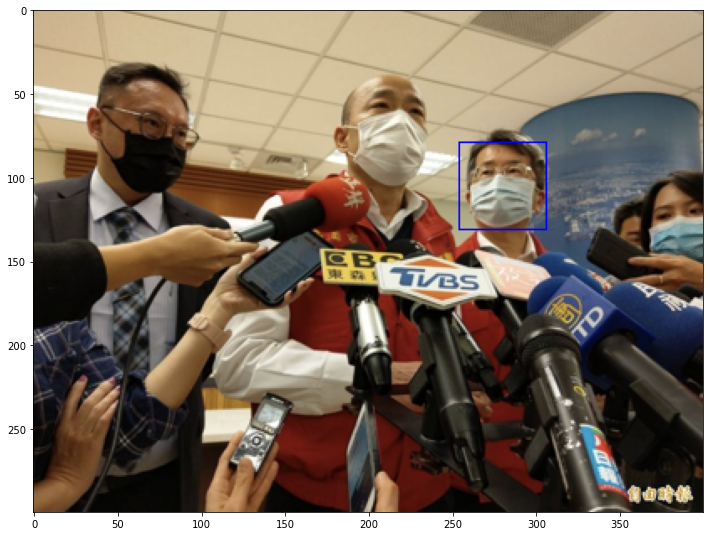

In [25]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('/home/hussein/Jupyter NoteBooks/Face Mask Detection/maksssksksss103.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.3, minNeighbors=5) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

### Detecting social distancing violations
This can be done by iterating over the coordinates of faces and calculating the distance for each possible pair, if the distance for a particular pair is less than MIN_DISTANCE then the bounding boxes for those faces are colored red. MIN_DISTANCE must be manually initialized in such a way that it corresponds to the minimum allowable distance in real life (ex. 6ft in India).

In [18]:
MIN_DISTANCE = 130

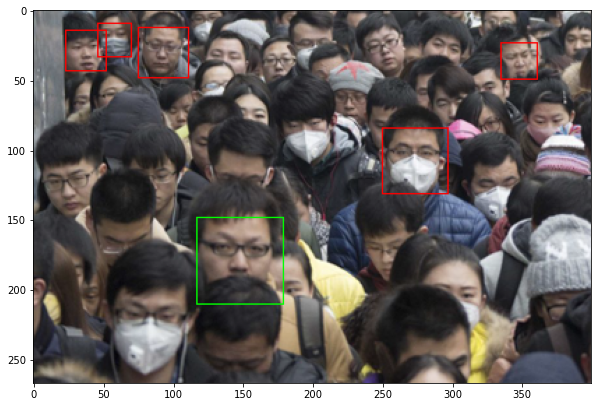

In [23]:
if len(faces) >= 2: 
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1,len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist < MIN_DISTANCE :
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i] == 1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
else :
    print("No. of faces detected is less than 2")
                

### Using VGG19 for mask detection


In [7]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [8]:
#Load train and test set
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [9]:

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [10]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [12]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
9/9 [==============================] - 7s 393ms/step - loss: 0.7459 - accuracy: 0.6297
Epoch 2/20
9/9 [==============================] - 3s 336ms/step - loss: 0.2958 - accuracy: 0.9213
Epoch 3/20
9/9 [==============================] - 3s 311ms/step - loss: 0.2216 - accuracy: 0.9028
Epoch 4/20
9/9 [==============================] - 3s 297ms/step - loss: 0.1721 - accuracy: 0.9242
Epoch 5/20
9/9 [==============================] - 3s 341ms/step - loss: 0.0988 - accuracy: 0.9689
Epoch 6/20
9/9 [==============================] - 3s 311ms/step - loss: 0.0973 - accuracy: 0.9730
Epoch 7/20
9/9 [==============================] - 3s 295ms/step - loss: 0.0909 - accuracy: 0.9782
Epoch 8/20
9/9 [==============================] - 3s 292ms/step - loss: 0.0754 - accuracy: 0.9847
Epoch 9/20
9/9 [==============================] - 3s 301ms/step - loss: 0.0657 - accuracy: 0.9777
Epoch 10/20
9/9 [==============================] - 3s 281ms/step - loss: 0.0769 - accuracy: 0.9820
Epoch 11/20
9/9 [==

<AxesSubplot:>

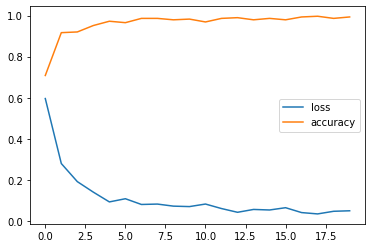

In [14]:
pd.DataFrame(history.history).plot()

In [15]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.05570352077484131, 0.9825000166893005]

In [16]:
model.save('masknet.h5')

In [29]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

In [30]:
from keras.models import load_model
model = load_model('masknet.h5')

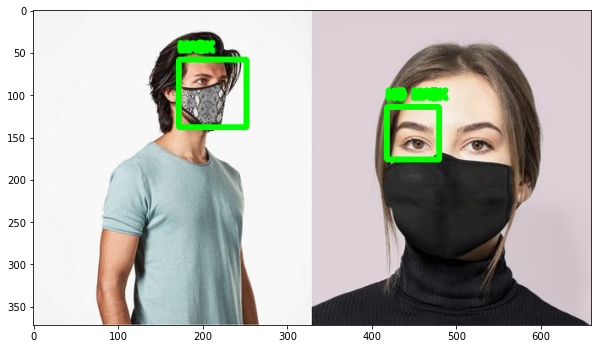

In [64]:
# '5558U_1073.jpg'
img = cv2.imread('/home/hussein/Jupyter NoteBooks/Face Mask Detection/7.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=2) #returns a list of (x,y,w,h) tuples


label = [0 for i in range(len(faces))]
for i in range(len(faces)-1):
    for j in range(i+1, len(faces)):
        dist = distance.euclidean(faces[i][:2],faces[j][:2])
        if dist<MIN_DISTANCE:
            label[i] = 1
            label[j] = 1
new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = model.predict(crop)
    cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],5)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],5)
plt.figure(figsize=(10,10))
plt.imshow(new_img)
